In [1]:
import pandas as pd
eye_tracking_data = pd.read_csv('data/raw_data_0317.csv')

In [2]:
# 查看data的结构
eye_tracking_data.head(1)

,Unnamed: 0,uid,page_id,text_sequences,eye_tracking_sequences,labels
0,0,ys,1226,"[[0, 'A', 330, 95, 32, 52], [1, 'judge', 362, ...","[[499, 499, 15], [499, 497, 10470], [497, 490,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [48]:
import math

class EyeTrackingDataEvaluate:
    def __init__(self, eye_tracking_data_list, window_size) -> None:
        self.data_list = eye_tracking_data_list # [x, y, timestamp, page_id]
        self.window_size = window_size

    def RmsScore(self) -> float:
        res = 0.0
        for i in range(len(self.data_list)):
            if i == 0:
                continue
            diff_x = self.data_list[i][0]-self.data_list[i-1][0]
            diff_y = self.data_list[i][1]-self.data_list[i-1][1]
            res += pow(diff_x, 2) + pow(diff_y, 2)
        res = math.sqrt(res/len(self.data_list))
        return res

    def STDWindowScore(self) -> float:
        res = 0.0
        dataCluster = [] # 记录聚合了的眼动
        for i in range(len(self.data_list)):
            if len(dataCluster) == 0:
                dataCluster.append(self.data_list[i])
            else:
                if self.data_list[i][2] - dataCluster[0][2] > self.window_size:
                    res += self.SquareVal(dataCluster)
                    dataCluster = []
                else:
                    dataCluster.append(self.data_list[i])
            if i == len(self.data_list) - 1 and len(dataCluster) > 0:
                res += self.SquareVal(dataCluster)
                dataCluster = []
        res = math.sqrt(res/len(self.data_list))
        return res

    def SquareVal(self, data_list):
        res = 0
        avg_x = sum([data[0] for data in data_list]) / len(data_list)
        avg_y = sum([data[1] for data in data_list]) / len(data_list)
        for data in data_list:
            res += pow(data[0] - avg_x, 2) + pow(data[1] - avg_y, 2)
        return res

    def FinalScore(self) -> int:
        rmsScore = self.RmsScore()
        stdScore = self.STDWindowScore()
        finalScore = math.sqrt(pow(rmsScore, 2) + pow(stdScore, 2))
        # print(f"finalScore={finalScore}, rmsScore={rmsScore}, stdScore={stdScore}")
        return finalScore

In [54]:
class EyeTrackingData:
    def __init__(self, eye_tracking_sequences, page_id) -> None:
        self.eye_tracking_sequences = eye_tracking_sequences
        self.page_id = page_id

In [62]:
# 构造数据
eye_tracking_data_list = [] # page维度
for idx, row in eye_tracking_data.iterrows():
    eye_tracking_data_list.append(EyeTrackingData(eval(row['eye_tracking_sequences']), row['page_id']))
print(len(eye_tracking_data_list))


214


In [63]:
# 组装数据
noise_degree_list = []
for data in eye_tracking_data_list:
    score = EyeTrackingDataEvaluate(eye_tracking_data_list=data.eye_tracking_sequences, 
                        window_size=300).FinalScore()
    noise_degree_list.append([score, data.page_id])
print(len(noise_degree_list))

214


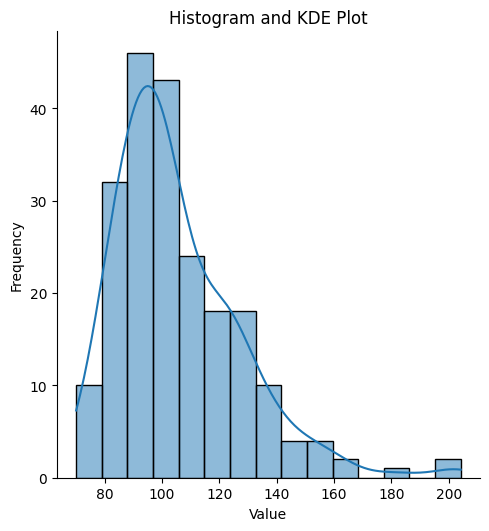

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot([x[0] for x in noise_degree_list], kde=True)  # kde=True 表示同时绘制核密度估计图
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram and KDE Plot')
plt.show()

In [79]:
# 确定异常的阈值
import numpy as np

mean = np.mean([x[0] for x in noise_degree_list]) # [score, page_id]
std = np.std([x[0] for x in noise_degree_list])

threshold = mean + 2 * std  # 假设以均值加上 2 个标准差为阈值

print("阈值为:", threshold)

阈值为: 149.59289047894688


In [80]:
# 拆分数据集
# 1. 先看超出阈值的有多少个
print([x for x in noise_degree_list if x[0] > 149])

[[166.83563761158283, 2671], [158.71707261137402, 2677], [152.2402431386577, 2691], [160.33176608373648, 2726], [156.42099064680048, 2752], [153.2314377574849, 2753], [199.80773952953072, 2762], [204.1865665726772, 2763], [181.86630522007613, 2787]]


In [82]:
# 测试拆分和人工判断的是否一致。
handcraft_skip_data_page = set()
skip_data_split_by_hand = pd.read_csv('data/skip_data.csv')
for idx, row in skip_data_split_by_hand.iterrows():
    handcraft_skip_data_page.add(row['page_id'])
error_cnt = 0
score_skip_data_page = [x[1] for x in noise_degree_list if x[0] > 149]
page_id_by_noise_degree = score_skip_data_page
for page_id in page_id_by_noise_degree:
    if page_id not in handcraft_skip_data_page:
        error_cnt+=1
print(error_cnt/len(score_skip_data_page))
# 不一致率很高，要找出几个case看看，到底哪种划分的方式更好。

0.6666666666666666


In [86]:
# 拆分数据集
condition = eye_tracking_data['page_id'].isin(score_skip_data_page)
skip_data = eye_tracking_data[condition]
not_skip_data = eye_tracking_data[~condition]
print(len(skip_data))
print(len(not_skip_data))
skip_data.to_csv('data/final_data/skip_data.csv')
not_skip_data.to_csv('data/final_data/not_skip_data.csv')

9
205
